# Unidirectional waveguide grating antenna

There has been a growing interest in using silicon photonic phased arrays for applications in light detection and ranging (LIDAR) and free-space communication. For these technologies to be effectively implemented, it is crucial to have large optical apertures. These apertures are necessary to maintain a small diffraction angle and ensure a large area for receiving signals. In the context of one-dimensional arrays, there has been extensive exploration of long waveguide grating antennas (WGAs). WGAs are created by introducing periodic perturbations in an integrated waveguide and have been a popular choice for achieving large apertures, as their length can be extended to several millimeters.

In this notebook, we demonstrate a unidirectional silicon nitride WGA with a dual-layer design based on the work `Manan Raval, Christopher V. Poulton, and Michael R. Watts, "Unidirectional waveguide grating antennas with uniform emission for optical phased arrays," Opt. Lett. 42, 2563-2566 (2017)` [DOI: 10.1364/OL.42.002563](https://doi.org/10.1364/OL.42.002563).

<img src="img/wga_schematic.png" width="400" alt="Schematic of the waveguide grating antenna">

For more integrated photonic examples such as the [8-Channel mode and polarization de-multiplexer](https://www.flexcompute.com/tidy3d/examples/notebooks/8ChannelDemultiplexer/), the [broadband bi-level taper polarization rotator-splitter](https://www.flexcompute.com/tidy3d/examples/notebooks/BilevelPSR/), and the [broadband directional coupler](https://www.flexcompute.com/tidy3d/examples/notebooks/BroadbandDirectionalCoupler/), please visit our [examples page](https://www.flexcompute.com/tidy3d/examples/).

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import tidy3d as td
import tidy3d.web as web
from tidy3d.plugins.mode import ModeSolver
from tidy3d.plugins.mode.web import run as run_mode_solver

## Design Optimization

In the first section of the notebook, we will design and optimize the WGA to ensure maximum unidirectional emission. This includes performing mode solving to calculate the effective indices of different waveguide sections and parameter sweeping the offset length between the two waveguides.

The WGA is designed to work at 1550 nm. Since FDTD simulation typically requires launching a broadband light source, we defined the central frequency of the pulse to be `td.C_0/(1.55 μm)`, where `td.C_0` is the speed of light in μm/s, and the frequency width to be 10% of the central frequency.

In [2]:
lda0 = 1.55  # central wavelength
freq0 = td.C_0 / lda0  # central frequency
fwidth = freq0 / 10  # width of the source frequency range

The waveguide is made of silicon nitride and the cladding is made of silicon oxide. Both materials can be imported from the [material library](https://docs.flexcompute.com/projects/tidy3d/en/latest/api/material_library.html#) directly. Note that the refractive index of the materials might not be identical to what is represented in the [reference](https://doi.org/10.1364/OL.42.002563). Therefore, the simulation results are not quantitatively comparable.

In [3]:
SiN = td.material_library["Si3N4"]["Luke2015PMLStable"]

SiO2 = td.material_library["SiO2"]["Palik_Lossless"]

Define geometric parameters including nitride layer thickness, gap size between the layers, and so on. In this particular case, we only model 10 periods of the gratings, similar to what is demonstrated in the [reference](https://doi.org/10.1364/OL.42.002563). Since Tidy3D can handle much larger simulations, a much longer WGA can be simulated in principle. 

In [4]:
t = 0.2  # silicon nitride layer thickness
w = 1  # waveguide width of the full width regions
gap = 0.1  # gap size between the layers
L_f = 0.5  # length of the full width regions
N = 10  # number of periods

### Mode Solving to Determine the Effective Indices

The WGA is engineered to emit vertically at a specific design wavelength of 1550 nm. Consequently, the dimensions of the four waveguide segments must be selected to ensure that the total optical path length for one cycle equals exactly one wavelength. That is, 

$$\lambda_0 = (L_f-L_0)n_{full} + (L_p(p)-L_0)n_s(p) + 2L_0n_a(p),$$

where $L_f$ is the length of the full width regions, $L_0$ is the offset in the direction of propagation between the two waveguides, $L_p$ is the length of the perturbed regions, $p$ is the perturbation value, $n_{full}$, $n_s$ and $n_a$ are the effective indices of different cross sections as indicated below as well as in Fig.2(a) of the [reference](https://doi.org/10.1364/OL.42.002563). 

<img src="img/wga_schematic_2.png" width="400" alt="Schematic of the waveguide grating antenna">

These effective indices can be calculated from mode solving. To do so, we define a function `cal_n_eff` that takes two arguments `p1` and `p2`, which represent the perturbations of the top waveguide and button waveguide, perform the mode solving, and return the effective index. 

In [5]:
def cal_n_eff(p1, p2):

    # define the top waveguide
    top_layer = td.Structure(
        geometry=td.Box(center=(0, 0, gap / 2 + t / 2), size=(td.inf, w - 2 * p1, t)), medium=SiN
    )

    # define the bottom waveguide
    bottom_layer = td.Structure(
        geometry=td.Box(center=(0, 0, -gap / 2 - t / 2), size=(td.inf, w - 2 * p2, t)), medium=SiN
    )

    # define a simulation for mode solving
    sim = td.Simulation(
        size=(1, 3 * w, 10 * t),
        grid_spec=td.GridSpec.auto(min_steps_per_wvl=50, wavelength=lda0),
        structures=[top_layer, bottom_layer],
        run_time=1e-12,
        boundary_spec=td.BoundarySpec.all_sides(boundary=td.PML()),
        medium=SiO2,
    )

    # defome a mode solver
    mode_spec = td.ModeSpec(num_modes=1, target_neff=2)
    mode_solver = ModeSolver(
        simulation=sim,
        plane=td.Box(size=(0, td.inf, td.inf)),
        mode_spec=mode_spec,
        freqs=[freq0],
    )

    # solver for the effective index
    mode_data = run_mode_solver(mode_solver, verbose=False)
    n_eff = mode_data.n_eff.values[0][0]

    return n_eff

$n_{full}$ is calculated by `p1=p2=0`. $n_a$ is calculated by `p1=p, p2=0`. And $n_s$ is calculated by `p1=p2=p`. Here we set $p$ to be 100 nm.

In [6]:
p = 0.1  # width perturbation

# calculate the effective indices
n_full = cal_n_eff(0, 0)
n_a = cal_n_eff(p, 0)
n_s = cal_n_eff(p, p)

### Parameter Sweep to Determine the Offset

A unidirectional emitter can be achieved by utilizing two scattering elements spaced a quarter wavelength apart. This arrangement generates constructive interference in one vertical direction while causing destructive interference in the opposite direction. In this example, the constant thicknesses of the silicon nitride layers and the separation gap hinder the achievement of full constructive interference for upward emission. Therefore, to find the optimal $L_0$, one needs to perform a parameter sweep to find the $L_0$ value such that the downward emission is minimized.

To do so, we define a helper function `make_sim` that takes a given $L_0$ and returns a simulation.

In [7]:
def make_sim(L_0):

    # calculate L_p
    L_p = (lda0 + L_0 * (n_full + n_s - 2 * n_a) - L_f * n_full) / n_s

    period = L_p + L_f  # periodic the grating

    # define the grating structures
    structures = []
    for i in range(N):

        structures.append(
            td.Structure(
                geometry=td.Box(
                    center=(L_p / 2 + i * period, 0, -gap / 2 - t / 2), size=(L_p, w - 2 * p, t)
                ),
                medium=SiN,
            )
        )

        structures.append(
            td.Structure(
                geometry=td.Box(
                    center=(L_p / 2 + L_0 + i * period, 0, gap / 2 + t / 2),
                    size=(L_p, w - 2 * p, t),
                ),
                medium=SiN,
            )
        )

        structures.append(
            td.Structure(
                geometry=td.Box(
                    center=(L_p + L_f / 2 + i * period, 0, -gap / 2 - t / 2), size=(L_f, w, t)
                ),
                medium=SiN,
            )
        )

        structures.append(
            td.Structure(
                geometry=td.Box(
                    center=(L_p + L_f / 2 + L_0 + i * period, 0, gap / 2 + t / 2), size=(L_f, w, t)
                ),
                medium=SiN,
            )
        )

    # create the input/output straight waveguide structures
    inf_eff = 1e3  # effective infinity

    structures.append(
        td.Structure(
            geometry=td.Box.from_bounds(
                rmin=(-inf_eff, -w / 2, -gap / 2 - t), rmax=(0, w / 2, -gap / 2)
            ),
            medium=SiN,
        )
    )

    structures.append(
        td.Structure(
            geometry=td.Box.from_bounds(
                rmin=(-inf_eff, -w / 2, gap / 2), rmax=(L_0, w / 2, gap / 2 + t)
            ),
            medium=SiN,
        )
    )

    structures.append(
        td.Structure(
            geometry=td.Box.from_bounds(
                rmin=(L_p + L_f / 2 + (N - 1) * period, -w / 2, -gap / 2 - t),
                rmax=(inf_eff, w / 2, -gap / 2),
            ),
            medium=SiN,
        )
    )

    structures.append(
        td.Structure(
            geometry=td.Box.from_bounds(
                rmin=(L_p + L_f / 2 + L_0 + (N - 1) * period, -w / 2, gap / 2),
                rmax=(inf_eff, w / 2, gap / 2 + t),
            ),
            medium=SiN,
        )
    )

    # define a mode source to launch the fundamental mode
    mode_spec = td.ModeSpec(num_modes=1, target_neff=2)
    mode_source = td.ModeSource(
        center=(-lda0, 0, 0),
        size=(0, 3 * w, 10 * t),
        source_time=td.GaussianPulse(freq0=freq0, fwidth=fwidth),
        direction="+",
        mode_spec=mode_spec,
        mode_index=0,
    )

    # define a flux monitor to measure downward radiation
    flux_down = td.FluxMonitor(
        center=(0, 0, -8 * t), size=(td.inf, td.inf, 0), freqs=[freq0], name="flux"
    )

    run_time = 5e-13  # simulation run time

    # define simulation
    sim = td.Simulation(
        center=(period * (N + 1) // 2, 0, 0),
        size=(2 * N * period, 4 * w, 20 * t),
        grid_spec=td.GridSpec.auto(min_steps_per_wvl=30, wavelength=lda0),
        structures=structures,
        sources=[mode_source],
        monitors=[flux_down],
        run_time=run_time,
        boundary_spec=td.BoundarySpec.all_sides(boundary=td.PML()),
        medium=SiO2,
        symmetry=(0, -1, 0),
    )

    return sim

To ensure the simulation setup is correct, we create a test simulation and visualize it.

In [8]:
sim = make_sim(0.25)
sim.plot_3d()

We perform a parameter sweep for $L_0$ from 100 nm to 250 nm to determine the optimal offset length.

In [9]:
L_0_list = np.linspace(0.1, 0.25, 16)  # range of the parameter sweep

# create simulations
sims = {f"L_0={L_0:.2f}": make_sim(L_0) for L_0 in L_0_list}

# create a batch and run it
batch = web.Batch(simulations=sims, verbose=True)
batch_results = batch.run(path_dir="data")

19:06:56 Eastern Standard Time Created task 'L_0=0.10' with task_id             
                               'fdve-bfbe7a17-bfc5-46b5-ace2-456fb2114e35' and  
                               task_type 'FDTD'.

                               View task using web UI at                        
                               ]8;id=158883;https://tidy3d.simulation.cloud/workbench?taskId=fdve-bfbe7a17-bfc5-46b5-ace2-456fb2114e35\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=459175;https://tidy3d.simulation.cloud/workbench?taskId=fdve-bfbe7a17-bfc5-46b5-ace2-456fb2114e35\taskId]8;;\
                               ]8;id=158883;https://tidy3d.simulation.cloud/workbench?taskId=fdve-bfbe7a17-bfc5-46b5-ace2-456fb2114e35\=]8;;\]8;id=973383;https://tidy3d.simulation.cloud/workbench?taskId=fdve-bfbe7a17-bfc5-46b5-ace2-456fb2114e35\fdve]8;;\]8;id=158883;https://tidy3d.simulation.cloud/workbench?taskId=fdve-bfbe7a17-bfc5-46b5-ace2-456fb2114e35\-bfbe7a17-bfc5-46b5-ace2-456fb2114e35']8;;\.

Output()

19:06:57 Eastern Standard Time Created task 'L_0=0.11' with task_id             
                               'fdve-4b2ea106-0c81-4e4b-a792-13606cdafdaa' and  
                               task_type 'FDTD'.

                               View task using web UI at                        
                               ]8;id=63455;https://tidy3d.simulation.cloud/workbench?taskId=fdve-4b2ea106-0c81-4e4b-a792-13606cdafdaa\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=865601;https://tidy3d.simulation.cloud/workbench?taskId=fdve-4b2ea106-0c81-4e4b-a792-13606cdafdaa\taskId]8;;\
                               ]8;id=63455;https://tidy3d.simulation.cloud/workbench?taskId=fdve-4b2ea106-0c81-4e4b-a792-13606cdafdaa\=]8;;\]8;id=641618;https://tidy3d.simulation.cloud/workbench?taskId=fdve-4b2ea106-0c81-4e4b-a792-13606cdafdaa\fdve]8;;\]8;id=63455;https://tidy3d.simulation.cloud/workbench?taskId=fdve-4b2ea106-0c81-4e4b-a792-13606cdafdaa\-4b2ea106-0c81-4e4b-a792-13606cdafdaa']8;;\.

Output()

19:06:58 Eastern Standard Time Created task 'L_0=0.12' with task_id             
                               'fdve-19a48718-718d-418b-8835-e06b0ce3c17d' and  
                               task_type 'FDTD'.

                               View task using web UI at                        
                               ]8;id=485934;https://tidy3d.simulation.cloud/workbench?taskId=fdve-19a48718-718d-418b-8835-e06b0ce3c17d\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=275050;https://tidy3d.simulation.cloud/workbench?taskId=fdve-19a48718-718d-418b-8835-e06b0ce3c17d\taskId]8;;\
                               ]8;id=485934;https://tidy3d.simulation.cloud/workbench?taskId=fdve-19a48718-718d-418b-8835-e06b0ce3c17d\=]8;;\]8;id=727655;https://tidy3d.simulation.cloud/workbench?taskId=fdve-19a48718-718d-418b-8835-e06b0ce3c17d\fdve]8;;\]8;id=485934;https://tidy3d.simulation.cloud/workbench?taskId=fdve-19a48718-718d-418b-8835-e06b0ce3c17d\-19a48718-718d-418b-8835-e06b0ce3c17d']8;;\.

Output()

19:06:59 Eastern Standard Time Created task 'L_0=0.13' with task_id             
                               'fdve-c1af01c8-b442-4f46-9778-5c5c64552044' and  
                               task_type 'FDTD'.

                               View task using web UI at                        
                               ]8;id=112997;https://tidy3d.simulation.cloud/workbench?taskId=fdve-c1af01c8-b442-4f46-9778-5c5c64552044\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=803107;https://tidy3d.simulation.cloud/workbench?taskId=fdve-c1af01c8-b442-4f46-9778-5c5c64552044\taskId]8;;\
                               ]8;id=112997;https://tidy3d.simulation.cloud/workbench?taskId=fdve-c1af01c8-b442-4f46-9778-5c5c64552044\=]8;;\]8;id=439512;https://tidy3d.simulation.cloud/workbench?taskId=fdve-c1af01c8-b442-4f46-9778-5c5c64552044\fdve]8;;\]8;id=112997;https://tidy3d.simulation.cloud/workbench?taskId=fdve-c1af01c8-b442-4f46-9778-5c5c64552044\-c1af01c8-b442-4f46-9778-5c5c64552044']8;;\.

Output()

19:07:00 Eastern Standard Time Created task 'L_0=0.14' with task_id             
                               'fdve-2ff7aac6-159d-4055-9052-bb071d3d48f2' and  
                               task_type 'FDTD'.

                               View task using web UI at                        
                               ]8;id=465543;https://tidy3d.simulation.cloud/workbench?taskId=fdve-2ff7aac6-159d-4055-9052-bb071d3d48f2\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=543274;https://tidy3d.simulation.cloud/workbench?taskId=fdve-2ff7aac6-159d-4055-9052-bb071d3d48f2\taskId]8;;\
                               ]8;id=465543;https://tidy3d.simulation.cloud/workbench?taskId=fdve-2ff7aac6-159d-4055-9052-bb071d3d48f2\=]8;;\]8;id=33814;https://tidy3d.simulation.cloud/workbench?taskId=fdve-2ff7aac6-159d-4055-9052-bb071d3d48f2\fdve]8;;\]8;id=465543;https://tidy3d.simulation.cloud/workbench?taskId=fdve-2ff7aac6-159d-4055-9052-bb071d3d48f2\-2ff7aac6-159d-4055-9052-bb071d3d48f2']8;;\.

Output()

19:07:01 Eastern Standard Time Created task 'L_0=0.15' with task_id             
                               'fdve-dbd2a56a-6c77-4475-933b-424e8fc74d1b' and  
                               task_type 'FDTD'.

                               View task using web UI at                        
                               ]8;id=640540;https://tidy3d.simulation.cloud/workbench?taskId=fdve-dbd2a56a-6c77-4475-933b-424e8fc74d1b\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=425226;https://tidy3d.simulation.cloud/workbench?taskId=fdve-dbd2a56a-6c77-4475-933b-424e8fc74d1b\taskId]8;;\
                               ]8;id=640540;https://tidy3d.simulation.cloud/workbench?taskId=fdve-dbd2a56a-6c77-4475-933b-424e8fc74d1b\=]8;;\]8;id=756088;https://tidy3d.simulation.cloud/workbench?taskId=fdve-dbd2a56a-6c77-4475-933b-424e8fc74d1b\fdve]8;;\]8;id=640540;https://tidy3d.simulation.cloud/workbench?taskId=fdve-dbd2a56a-6c77-4475-933b-424e8fc74d1b\-dbd2a56a-6c77-4475-933b-424e8fc74d1b']8;;\.

Output()

19:07:02 Eastern Standard Time Created task 'L_0=0.16' with task_id             
                               'fdve-bebc6827-3cf7-4b94-bb2c-3eedd7d3afa3' and  
                               task_type 'FDTD'.

                               View task using web UI at                        
                               ]8;id=218592;https://tidy3d.simulation.cloud/workbench?taskId=fdve-bebc6827-3cf7-4b94-bb2c-3eedd7d3afa3\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=235269;https://tidy3d.simulation.cloud/workbench?taskId=fdve-bebc6827-3cf7-4b94-bb2c-3eedd7d3afa3\taskId]8;;\
                               ]8;id=218592;https://tidy3d.simulation.cloud/workbench?taskId=fdve-bebc6827-3cf7-4b94-bb2c-3eedd7d3afa3\=]8;;\]8;id=683366;https://tidy3d.simulation.cloud/workbench?taskId=fdve-bebc6827-3cf7-4b94-bb2c-3eedd7d3afa3\fdve]8;;\]8;id=218592;https://tidy3d.simulation.cloud/workbench?taskId=fdve-bebc6827-3cf7-4b94-bb2c-3eedd7d3afa3\-bebc6827-3cf7-4b94-bb2c-3eedd7d3afa3']8;;\.

Output()

                               Created task 'L_0=0.17' with task_id             
                               'fdve-3e9eb8c8-97bd-4e0e-a795-47a298bf3e01' and  
                               task_type 'FDTD'.

                               View task using web UI at                        
                               ]8;id=271520;https://tidy3d.simulation.cloud/workbench?taskId=fdve-3e9eb8c8-97bd-4e0e-a795-47a298bf3e01\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=81058;https://tidy3d.simulation.cloud/workbench?taskId=fdve-3e9eb8c8-97bd-4e0e-a795-47a298bf3e01\taskId]8;;\
                               ]8;id=271520;https://tidy3d.simulation.cloud/workbench?taskId=fdve-3e9eb8c8-97bd-4e0e-a795-47a298bf3e01\=]8;;\]8;id=995168;https://tidy3d.simulation.cloud/workbench?taskId=fdve-3e9eb8c8-97bd-4e0e-a795-47a298bf3e01\fdve]8;;\]8;id=271520;https://tidy3d.simulation.cloud/workbench?taskId=fdve-3e9eb8c8-97bd-4e0e-a795-47a298bf3e01\-3e9eb8c8-97bd-4e0e-a795-47a298bf3e01']8;;\.

Output()

19:07:03 Eastern Standard Time Created task 'L_0=0.18' with task_id             
                               'fdve-df9d41a7-4829-427a-b52a-9acb38aa7c60' and  
                               task_type 'FDTD'.

                               View task using web UI at                        
                               ]8;id=129389;https://tidy3d.simulation.cloud/workbench?taskId=fdve-df9d41a7-4829-427a-b52a-9acb38aa7c60\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=510782;https://tidy3d.simulation.cloud/workbench?taskId=fdve-df9d41a7-4829-427a-b52a-9acb38aa7c60\taskId]8;;\
                               ]8;id=129389;https://tidy3d.simulation.cloud/workbench?taskId=fdve-df9d41a7-4829-427a-b52a-9acb38aa7c60\=]8;;\]8;id=540140;https://tidy3d.simulation.cloud/workbench?taskId=fdve-df9d41a7-4829-427a-b52a-9acb38aa7c60\fdve]8;;\]8;id=129389;https://tidy3d.simulation.cloud/workbench?taskId=fdve-df9d41a7-4829-427a-b52a-9acb38aa7c60\-df9d41a7-4829-427a-b52a-9acb38aa7c60']8;;\.

Output()

19:07:04 Eastern Standard Time Created task 'L_0=0.19' with task_id             
                               'fdve-6bfd86ec-fae8-4133-870e-f448e7af15a3' and  
                               task_type 'FDTD'.

                               View task using web UI at                        
                               ]8;id=66503;https://tidy3d.simulation.cloud/workbench?taskId=fdve-6bfd86ec-fae8-4133-870e-f448e7af15a3\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=87387;https://tidy3d.simulation.cloud/workbench?taskId=fdve-6bfd86ec-fae8-4133-870e-f448e7af15a3\taskId]8;;\
                               ]8;id=66503;https://tidy3d.simulation.cloud/workbench?taskId=fdve-6bfd86ec-fae8-4133-870e-f448e7af15a3\=]8;;\]8;id=784138;https://tidy3d.simulation.cloud/workbench?taskId=fdve-6bfd86ec-fae8-4133-870e-f448e7af15a3\fdve]8;;\]8;id=66503;https://tidy3d.simulation.cloud/workbench?taskId=fdve-6bfd86ec-fae8-4133-870e-f448e7af15a3\-6bfd86ec-fae8-4133-870e-f448e7af15a3']8;;\.

Output()

19:07:05 Eastern Standard Time Created task 'L_0=0.20' with task_id             
                               'fdve-56075e65-57d3-4ce8-8f1a-c23fa93ee978' and  
                               task_type 'FDTD'.

                               View task using web UI at                        
                               ]8;id=533309;https://tidy3d.simulation.cloud/workbench?taskId=fdve-56075e65-57d3-4ce8-8f1a-c23fa93ee978\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=485193;https://tidy3d.simulation.cloud/workbench?taskId=fdve-56075e65-57d3-4ce8-8f1a-c23fa93ee978\taskId]8;;\
                               ]8;id=533309;https://tidy3d.simulation.cloud/workbench?taskId=fdve-56075e65-57d3-4ce8-8f1a-c23fa93ee978\=]8;;\]8;id=496775;https://tidy3d.simulation.cloud/workbench?taskId=fdve-56075e65-57d3-4ce8-8f1a-c23fa93ee978\fdve]8;;\]8;id=533309;https://tidy3d.simulation.cloud/workbench?taskId=fdve-56075e65-57d3-4ce8-8f1a-c23fa93ee978\-56075e65-57d3-4ce8-8f1a-c23fa93ee978']8;;\.

Output()

19:07:06 Eastern Standard Time Created task 'L_0=0.21' with task_id             
                               'fdve-4c29fdc9-b531-470d-8bcd-c7c401c27cbf' and  
                               task_type 'FDTD'.

                               View task using web UI at                        
                               ]8;id=294713;https://tidy3d.simulation.cloud/workbench?taskId=fdve-4c29fdc9-b531-470d-8bcd-c7c401c27cbf\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=366586;https://tidy3d.simulation.cloud/workbench?taskId=fdve-4c29fdc9-b531-470d-8bcd-c7c401c27cbf\taskId]8;;\
                               ]8;id=294713;https://tidy3d.simulation.cloud/workbench?taskId=fdve-4c29fdc9-b531-470d-8bcd-c7c401c27cbf\=]8;;\]8;id=963342;https://tidy3d.simulation.cloud/workbench?taskId=fdve-4c29fdc9-b531-470d-8bcd-c7c401c27cbf\fdve]8;;\]8;id=294713;https://tidy3d.simulation.cloud/workbench?taskId=fdve-4c29fdc9-b531-470d-8bcd-c7c401c27cbf\-4c29fdc9-b531-470d-8bcd-c7c401c27cbf']8;;\.

Output()

19:07:07 Eastern Standard Time Created task 'L_0=0.22' with task_id             
                               'fdve-ce109dd3-3b23-4f5a-86b7-96b933d60325' and  
                               task_type 'FDTD'.

                               View task using web UI at                        
                               ]8;id=706917;https://tidy3d.simulation.cloud/workbench?taskId=fdve-ce109dd3-3b23-4f5a-86b7-96b933d60325\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=638234;https://tidy3d.simulation.cloud/workbench?taskId=fdve-ce109dd3-3b23-4f5a-86b7-96b933d60325\taskId]8;;\
                               ]8;id=706917;https://tidy3d.simulation.cloud/workbench?taskId=fdve-ce109dd3-3b23-4f5a-86b7-96b933d60325\=]8;;\]8;id=172136;https://tidy3d.simulation.cloud/workbench?taskId=fdve-ce109dd3-3b23-4f5a-86b7-96b933d60325\fdve]8;;\]8;id=706917;https://tidy3d.simulation.cloud/workbench?taskId=fdve-ce109dd3-3b23-4f5a-86b7-96b933d60325\-ce109dd3-3b23-4f5a-86b7-96b933d60325']8;;\.

Output()

19:07:08 Eastern Standard Time Created task 'L_0=0.23' with task_id             
                               'fdve-19e0d919-8797-4985-bd7f-7ece732254c7' and  
                               task_type 'FDTD'.

                               View task using web UI at                        
                               ]8;id=421586;https://tidy3d.simulation.cloud/workbench?taskId=fdve-19e0d919-8797-4985-bd7f-7ece732254c7\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=430448;https://tidy3d.simulation.cloud/workbench?taskId=fdve-19e0d919-8797-4985-bd7f-7ece732254c7\taskId]8;;\
                               ]8;id=421586;https://tidy3d.simulation.cloud/workbench?taskId=fdve-19e0d919-8797-4985-bd7f-7ece732254c7\=]8;;\]8;id=280753;https://tidy3d.simulation.cloud/workbench?taskId=fdve-19e0d919-8797-4985-bd7f-7ece732254c7\fdve]8;;\]8;id=421586;https://tidy3d.simulation.cloud/workbench?taskId=fdve-19e0d919-8797-4985-bd7f-7ece732254c7\-19e0d919-8797-4985-bd7f-7ece732254c7']8;;\.

Output()

19:07:09 Eastern Standard Time Created task 'L_0=0.24' with task_id             
                               'fdve-22ca7abc-5217-4d6b-a2e4-755977cbb5bf' and  
                               task_type 'FDTD'.

                               View task using web UI at                        
                               ]8;id=696843;https://tidy3d.simulation.cloud/workbench?taskId=fdve-22ca7abc-5217-4d6b-a2e4-755977cbb5bf\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=200308;https://tidy3d.simulation.cloud/workbench?taskId=fdve-22ca7abc-5217-4d6b-a2e4-755977cbb5bf\taskId]8;;\
                               ]8;id=696843;https://tidy3d.simulation.cloud/workbench?taskId=fdve-22ca7abc-5217-4d6b-a2e4-755977cbb5bf\=]8;;\]8;id=240878;https://tidy3d.simulation.cloud/workbench?taskId=fdve-22ca7abc-5217-4d6b-a2e4-755977cbb5bf\fdve]8;;\]8;id=696843;https://tidy3d.simulation.cloud/workbench?taskId=fdve-22ca7abc-5217-4d6b-a2e4-755977cbb5bf\-22ca7abc-5217-4d6b-a2e4-755977cbb5bf']8;;\.

Output()

19:07:10 Eastern Standard Time Created task 'L_0=0.25' with task_id             
                               'fdve-e72baff0-5b7a-447b-bd87-9478c126e088' and  
                               task_type 'FDTD'.

                               View task using web UI at                        
                               ]8;id=591715;https://tidy3d.simulation.cloud/workbench?taskId=fdve-e72baff0-5b7a-447b-bd87-9478c126e088\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=83718;https://tidy3d.simulation.cloud/workbench?taskId=fdve-e72baff0-5b7a-447b-bd87-9478c126e088\taskId]8;;\
                               ]8;id=591715;https://tidy3d.simulation.cloud/workbench?taskId=fdve-e72baff0-5b7a-447b-bd87-9478c126e088\=]8;;\]8;id=706950;https://tidy3d.simulation.cloud/workbench?taskId=fdve-e72baff0-5b7a-447b-bd87-9478c126e088\fdve]8;;\]8;id=591715;https://tidy3d.simulation.cloud/workbench?taskId=fdve-e72baff0-5b7a-447b-bd87-9478c126e088\-e72baff0-5b7a-447b-bd87-9478c126e088']8;;\.

Output()

19:07:24 Eastern Standard Time Started working on Batch.

19:07:34 Eastern Standard Time Maximum FlexCredit cost: 1.227 for the whole     
                               batch.

                               Use 'Batch.real_cost()' to get the billed        
                               FlexCredit cost after the Batch has completed.

Output()

19:08:11 Eastern Standard Time Batch complete.

Extract the downward radiation flux from the sweep.

In [10]:
downward_radiation = []

for L_0 in L_0_list:
    sim_data = batch_results[f"L_0={L_0:.2f}"]
    downward_radiation.append(np.abs(sim_data["flux"].flux))

Output()

19:08:15 Eastern Standard Time loading simulation from                          
                               data\fdve-bfbe7a17-bfc5-46b5-ace2-456fb2114e35.hd
                               f5

Output()

19:08:16 Eastern Standard Time loading simulation from                          
                               data\fdve-4b2ea106-0c81-4e4b-a792-13606cdafdaa.hd
                               f5

Output()

19:08:17 Eastern Standard Time loading simulation from                          
                               data\fdve-19a48718-718d-418b-8835-e06b0ce3c17d.hd
                               f5

Output()

19:08:18 Eastern Standard Time loading simulation from                          
                               data\fdve-c1af01c8-b442-4f46-9778-5c5c64552044.hd
                               f5

Output()

19:08:19 Eastern Standard Time loading simulation from                          
                               data\fdve-2ff7aac6-159d-4055-9052-bb071d3d48f2.hd
                               f5

Output()

19:08:20 Eastern Standard Time loading simulation from                          
                               data\fdve-dbd2a56a-6c77-4475-933b-424e8fc74d1b.hd
                               f5

Output()

19:08:21 Eastern Standard Time loading simulation from                          
                               data\fdve-bebc6827-3cf7-4b94-bb2c-3eedd7d3afa3.hd
                               f5

Output()

19:08:22 Eastern Standard Time loading simulation from                          
                               data\fdve-3e9eb8c8-97bd-4e0e-a795-47a298bf3e01.hd
                               f5

Output()

19:08:23 Eastern Standard Time loading simulation from                          
                               data\fdve-df9d41a7-4829-427a-b52a-9acb38aa7c60.hd
                               f5

Output()

19:08:24 Eastern Standard Time loading simulation from                          
                               data\fdve-6bfd86ec-fae8-4133-870e-f448e7af15a3.hd
                               f5

Output()

19:08:25 Eastern Standard Time loading simulation from                          
                               data\fdve-56075e65-57d3-4ce8-8f1a-c23fa93ee978.hd
                               f5

Output()

19:08:26 Eastern Standard Time loading simulation from                          
                               data\fdve-4c29fdc9-b531-470d-8bcd-c7c401c27cbf.hd
                               f5

Output()

19:08:27 Eastern Standard Time loading simulation from                          
                               data\fdve-ce109dd3-3b23-4f5a-86b7-96b933d60325.hd
                               f5

Output()

19:08:28 Eastern Standard Time loading simulation from                          
                               data\fdve-19e0d919-8797-4985-bd7f-7ece732254c7.hd
                               f5

Output()

19:08:29 Eastern Standard Time loading simulation from                          
                               data\fdve-22ca7abc-5217-4d6b-a2e4-755977cbb5bf.hd
                               f5

Output()

19:08:30 Eastern Standard Time loading simulation from                          
                               data\fdve-e72baff0-5b7a-447b-bd87-9478c126e088.hd
                               f5

Plot the downward radiation flux as a function of $L_0$. Then determine the optimal $L_0$.

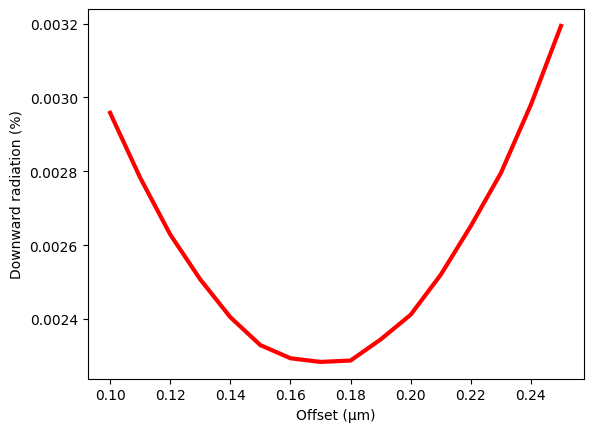

The optimal offset is 170.0 nm


In [11]:
plt.plot(L_0_list, downward_radiation, linewidth=3, c="red")
plt.xlabel("Offset (μm)")
plt.ylabel("Downward radiation (%)")
plt.show()

# find the offset that results in minimal downward radiation
i = np.argmin(downward_radiation)
L_0_opt = L_0_list[i]
print(f"The optimal offset is {L_0_opt*1e3} nm")

## Radiation Pattern of the Optimal Design

To simulate the optimal design, we also define two [FieldProjectionAngleMonitor](https://docs.flexcompute.com/projects/tidy3d/en/latest/api/_autosummary/tidy3d.FieldProjectionAngleMonitor.html) objects to compute the far-field radiation pattern upward and downward. 

In [12]:
sim_opt = make_sim(L_0_opt)  # create simulation for the optimal design

# define field projection angle ranges
theta_array = np.linspace(0, np.deg2rad(60), 100)  # polar angle
phi_array = np.linspace(0, 2 * np.pi, 200)  # azimuthal angle

# define the top field projection monitor
monitor_top = td.FieldProjectionAngleMonitor(
    name="top",
    center=(0, 0, 8 * t),
    size=(td.inf, td.inf, 0),
    freqs=[freq0],
    theta=theta_array,
    phi=phi_array,
)

# define the bottom field projection monitor
monitor_bottom = td.FieldProjectionAngleMonitor(
    name="bottom",
    normal_dir="-",
    center=(0, 0, -8 * t),
    size=(td.inf, td.inf, 0),
    freqs=[freq0],
    theta=np.pi - theta_array,
    phi=phi_array,
)

# add the field projection monitors to the simulation
sim_opt = sim_opt.copy(update={"monitors": [monitor_top, monitor_bottom]})

# run the simulation
sim_data_opt = web.run(simulation=sim_opt, task_name="optimized wga")

                               Created task 'optimized wga' with task_id        
                               'fdve-f4f0aae2-c261-4760-ae41-37e7d098700c' and  
                               task_type 'FDTD'.

                               View task using web UI at                        
                               ]8;id=238621;https://tidy3d.simulation.cloud/workbench?taskId=fdve-f4f0aae2-c261-4760-ae41-37e7d098700c\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=594808;https://tidy3d.simulation.cloud/workbench?taskId=fdve-f4f0aae2-c261-4760-ae41-37e7d098700c\taskId]8;;\
                               ]8;id=238621;https://tidy3d.simulation.cloud/workbench?taskId=fdve-f4f0aae2-c261-4760-ae41-37e7d098700c\=]8;;\]8;id=53612;https://tidy3d.simulation.cloud/workbench?taskId=fdve-f4f0aae2-c261-4760-ae41-37e7d098700c\fdve]8;;\]8;id=238621;https://tidy3d.simulation.cloud/workbench?taskId=fdve-f4f0aae2-c261-4760-ae41-37e7d098700c\-f4f0aae2-c261-4760-ae41-37e7d098700c']8;;\.

Output()

19:08:32 Eastern Standard Time status = queued

Output()

19:09:39 Eastern Standard Time status = preprocess

19:09:41 Eastern Standard Time Maximum FlexCredit cost: 0.081. Use              
                               'web.real_cost(task_id)' to get the billed       
                               FlexCredit cost after a simulation run.

                               starting up solver

                               running solver

                               To cancel the simulation, use                    
                               'web.abort(task_id)' or 'web.delete(task_id)' or 
                               abort/delete the task in the web UI. Terminating 
                               the Python script will not stop the job running  
                               on the cloud.

Output()

19:10:02 Eastern Standard Time early shutoff detected at 40%, exiting.

                               status = postprocess

Output()

19:10:06 Eastern Standard Time status = success

                               View simulation result at                        
                               ]8;id=3911;https://tidy3d.simulation.cloud/workbench?taskId=fdve-f4f0aae2-c261-4760-ae41-37e7d098700c\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=372404;https://tidy3d.simulation.cloud/workbench?taskId=fdve-f4f0aae2-c261-4760-ae41-37e7d098700c\taskId]8;;\
                               ]8;id=3911;https://tidy3d.simulation.cloud/workbench?taskId=fdve-f4f0aae2-c261-4760-ae41-37e7d098700c\=]8;;\]8;id=627899;https://tidy3d.simulation.cloud/workbench?taskId=fdve-f4f0aae2-c261-4760-ae41-37e7d098700c\fdve]8;;\]8;id=3911;https://tidy3d.simulation.cloud/workbench?taskId=fdve-f4f0aae2-c261-4760-ae41-37e7d098700c\-f4f0aae2-c261-4760-ae41-37e7d098700c']8;;\.

Output()

19:10:08 Eastern Standard Time loading simulation from simulation_data.hdf5

Plot the normalized upward radiation pattern. 

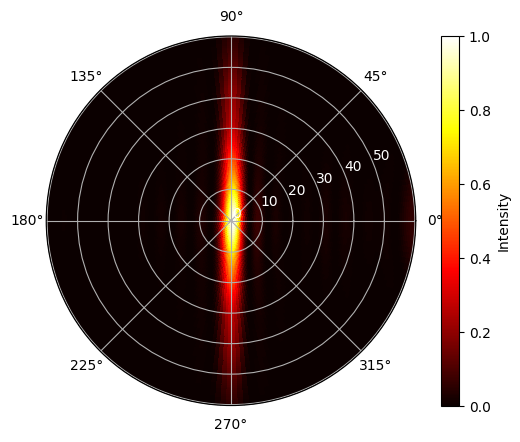

In [13]:
P = sim_data_opt["top"].power.squeeze(drop=True)  # extract upward radiated power
P_max = np.max(P)
P_norm = P / P_max

# plot the radiation pattern in polar coordinates
fig = plt.figure()
ax = fig.add_subplot(111, polar=True)
c = ax.pcolor(
    phi_array, np.rad2deg(theta_array), P_norm, shading="auto", cmap="hot", vmin=0, vmax=1
)
cb = fig.colorbar(c, ax=ax)
cb.set_label("Intensity")
_ = plt.setp(ax.get_yticklabels(), color="white")

Plot the normalized downward radiation pattern on the same color scale. In comparison, we can see that the downward radiation is nearly invisible since it is orders of magnitude weaker than the upward radiation as desired. 

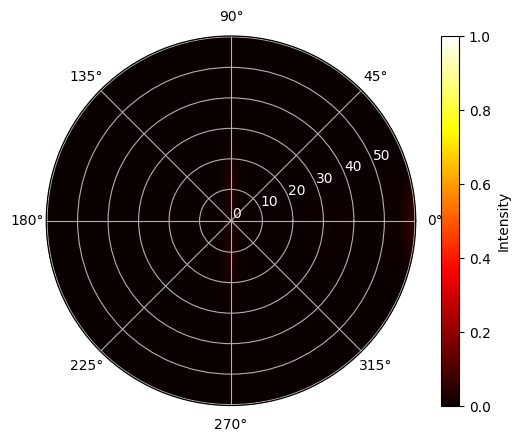

In [14]:
P = sim_data_opt["bottom"].power.squeeze(drop=True)  # extract downward radiated power
P_norm = P / P_max

# plot the radiation pattern in polar coordinates
fig = plt.figure()
ax = fig.add_subplot(111, polar=True)
c = ax.pcolor(
    phi_array, np.rad2deg(theta_array), P_norm, shading="auto", cmap="hot", vmin=0, vmax=1
)
cb = fig.colorbar(c, ax=ax)
cb.set_label("Intensity")
_ = plt.setp(ax.get_yticklabels(), color="white")